# Projet P6 : Classifiez automatiquement des biens de consommation

## Contexte

<b> MISSION 1 : </b>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 
- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
 
Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ? 

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
 
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

<b> MISSION 2 : </b>

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fine. 
Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’API disponible  ici ?
https://developer.edamam.com/food-database-api

Pourrais-tu ensuite nous proposer un script ou notebook Python permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Etapes du projet :

Démontrer la faisabilité de regrouper automatiquement des produits de même catégorie.

- <b> Etape préliminaire : </b> Importation des données ( --> NoteBook1 : Traitement des textes )
- <b> Etape 1 : </b> Text cleaning et feature engineering ( --> NoteBook1 : Traitement des textes ) 
- <b> Etape 2 : </b> Catégorisation des descriptions ( --> NoteBook 2 et 3 : Méthodes bag of words et Word_embedding )
- <b> Etape 3 : </b> Pré-traitement et classification d'images (SIFT et CNN) ( --> NoteBook4 : Traitement des images )
- <b> Etape 4 : </b> Classification supervisée des images ( --> NoteBook5 : Classification des images )
- <b> Etape 5 : </b> Collecte de produits via API ( --> NoteBook6 : Collecte produits API )

Livrables : 
- Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité)
- Un notebook de classification supervisée des images
- Un script Python (notebook ou fichier .py) de test de l’API et le fichier au format “csv” contenant les produits extraits

### Environnement de travail et librairies

In [1]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\python.exe
3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


In [ ]:
# Builtin
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'

# Data
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt

# NLTK 
import string

# NLP - tensorflow
import tensorflow as tf

# Tensorflow hub
import tensorflow_hub as hub
import tensorflow_text

# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

# Clustering
from sklearn import cluster, metrics

# Reduction dimension
from sklearn import manifold, decomposition

### Importation des données d'origine

In [66]:
articles_text_BERT = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_BERT.csv")
articles_text_BERT.head()

,description,category_product
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


### Importation des données cleanées

In [69]:
articles_text_clean = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_clean.csv")
articles_text_clean.head()

,tokens,description,category_product
0,"['key', 'feature', 'elegance', 'polyester', 'm...",key feature elegance polyester multicolor abst...,Home Furnishing
1,"['specification', 'cotton', 'bath', 'towel', '...",specification cotton bath towel bath towel red...,Baby Care
2,"['key', 'feature', 'eurospa', 'cotton', 'terry...",key feature eurospa cotton terry face towel se...,Baby Care
3,"['key', 'feature', 'santosh', 'royal', 'fashio...",key feature santosh royal fashion cotton print...,Home Furnishing
4,"['key', 'feature', 'jaipur', 'print', 'cotton'...",key feature jaipur print cotton floral king si...,Home Furnishing


In [71]:
# Convertir les chaînes en listes de tokens
import ast
articles_text_clean['tokens'] = articles_text_clean['tokens'].apply(ast.literal_eval)
articles_text_clean.head()

,tokens,description,category_product
0,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...,Home Furnishing
1,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...,Baby Care
2,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...,Baby Care
3,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...,Home Furnishing
4,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...,Home Furnishing


In [73]:
# Afficher la longueur des tokens 
df = articles_text_clean.copy()
df['token_count'] = df['tokens'].apply(len)

# Trouver le nombre maximum de tokens
max_tokens = df['token_count'].max()
print(f"Le nombre maximum de tokens dans la colonne 'tokens' est : {max_tokens}")

Le nombre maximum de tokens dans la colonne 'tokens' est : 285


## ETAPE 2 : Catégorisation des descriptions (étude de faisabilité)

ETAPE 2
    
    1. Encodage simple (méthodes Bag of words)
        1. Comptage simple (CountVectorizer)
        2. Tf_IDF
    2. Encodage complexe (algo de word embeddings)
        1. Word2Vec
        2. BERT
        3. Universal Sentence Encoder

### 2. Encodage complexe - Word Embeddings

#### *** Fonctions communes ***

In [79]:
l_cat = list(set(articles_text_clean['category_product']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(articles_text_clean.iloc[i]['category_product'])) for i in range(len(articles_text_clean))]

catégories :  ['Home Furnishing', 'Watches', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Computers', 'Baby Care', 'Beauty and Personal Care']


In [81]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, max_iter=2000, init='random', random_state=42)
    # tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=10, random_state=42)
    # cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

#### 2. BERT

In [84]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
Num GPUs Available:  0
True


#### *** Fonctions communes ***

In [87]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    
    # Initialisation des listes pour stocker les données transformées
    input_ids = [] # Stocke les IDs des tokens pour chaque phrase.
    token_type_ids = [] # Stocke les IDs des types de tokens. Utilisé pour les tâches impliquant des paires de phrases.
    attention_mask = [] # Stocke les masques d'attention. Indique les tokens à prendre en compte (1) ou à ignorer (0).
    bert_inp_tot = [] # Stocke des tuples contenant les input_ids, token_type_ids et attention_mask pour chaque phrase.

    # Boucle sur chaque phrase dans la liste de phrases : utilisez bert_tokenizer.encode_plus pour transformer la phrase en un format compatible avec BERT
    for sent in sentences:
        # Utilisation de la méthode encode_plus du tokenizer BERT pour transformer la phrase
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,         # Ajout des tokens spéciaux (CLS, SEP) utilisés par BERT
            max_length=max_length,           # Longueur maximale des séquences
            padding='max_length',            # Remplissage des séquences à la longueur maximale
            return_attention_mask=True,      # Retourner le masque d'attention
            return_token_type_ids=True,      # Retourner les IDs de type de token (utilisés pour les tâches avec paires de phrases)
            truncation=True,                 # Troncature des séquences plus longues que max_length
            return_tensors="tf"              # Retourner les tenseurs TensorFlow
        )

        # Ajouter les résultats aux listes respectives
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    # Conversion des listes en tableaux numpy pour une utilisation plus facile avec TensorFlow
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    # Retourner les tableaux numpy et la liste des tuples contenant toutes les informations
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features : utilisation d'un modèle BERT pour générer des embeddings à partir de phrases données
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size  # Taille des lots pour la création des features
    batch_size_pred = b_size  # Taille des lots pour la prédiction
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)  # Initialisation du tokenizer BERT à partir du modèle spécifié
    time1 = time.time()  # Enregistrement du temps de début pour mesurer la durée du traitement

    # Boucle sur chaque lot de phrases, la boucle traite les phrases par lots de taille batch_size, idx calcule l'indice de début du lot actuel
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size  # Calcul de l'indice de début du lot actuel
        # Préparation des entrées pour BERT : bert_inp_fct transforme les phrases en entrées compatibles avec BERT (fonction ci-dessus)
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size], 
                                                                              bert_tokenizer, max_length)
        # Mode Hugging Face
        if mode == 'HF':
            # Utilise le modèle BERT pour prédire les embeddings des phrases
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state # outputs.last_hidden_state contient les états cachés de la dernière couche de BERT

        # Mode TensorFlow Hub
        if mode == 'TFhub':
            # Prépare les données pour le modèle TensorFlow Hub
            text_preprocessed = {
                "input_word_ids": input_ids, 
                "input_mask": attention_mask, 
                "input_type_ids": token_type_ids
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output'] # Utilise le modèle pour obtenir les états cachés des séquences
        
        # Concaténer les états cachés du modèle BERT, si c'est le premier lot, initialisez last_hidden_states_tot, 
        # Sinon, concaténez les états cachés du lot actuel avec ceux des lots précédents
        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    
    # Calcul des features en prenant la moyenne des états cachés sur l'axe 1 (tokens)
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    # Calcul du temps total de traitement
    time2 = np.round(time.time() - time1, 0) # time2 mesure et affiche le temps total de traitement.
    print("temps traitement : ", time2)

    # La fonction retourne les features_bert (features moyennes pour chaque phrase) et last_hidden_states_tot (tous les états cachés concaténés)
    return features_bert, last_hidden_states_tot

In [89]:
# Reprendre les descriptions d'origine pour traitement avec BERT, appliquer les minuscules et ponctuation
def clean_sentence(sentence):
    # enlever la ponctuation et les majuscules
    return "".join([i.lower() for i in sentence if i not in string.punctuation])

# Appliquer la fonction de nettoyage à chaque description
articles_text_BERT['cleaned_description'] = articles_text_BERT['description'].apply(clean_sentence)

#### -- BERT hub Tensorflow : 'bert-base-uncased' --

Guide sur le Tensorflow hub : Ce didacticiel contient un code complet pour affiner BERT afin d'effectuer une analyse des sentiments sur un ensemble de données de critiques de films IMDB en texte brut. En plus de la formation d'un modèle, vous apprendrez à prétraiter le texte dans un format approprié.
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [93]:
print(tf.__version__)

2.10.1


In [95]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [96]:
sentences = articles_text_BERT['cleaned_description'].to_list() # Données en entrée

In [143]:
# Définition des paramètres
max_length = 30
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t

temps traitement :  31.0


In [144]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4684 time :  7.0


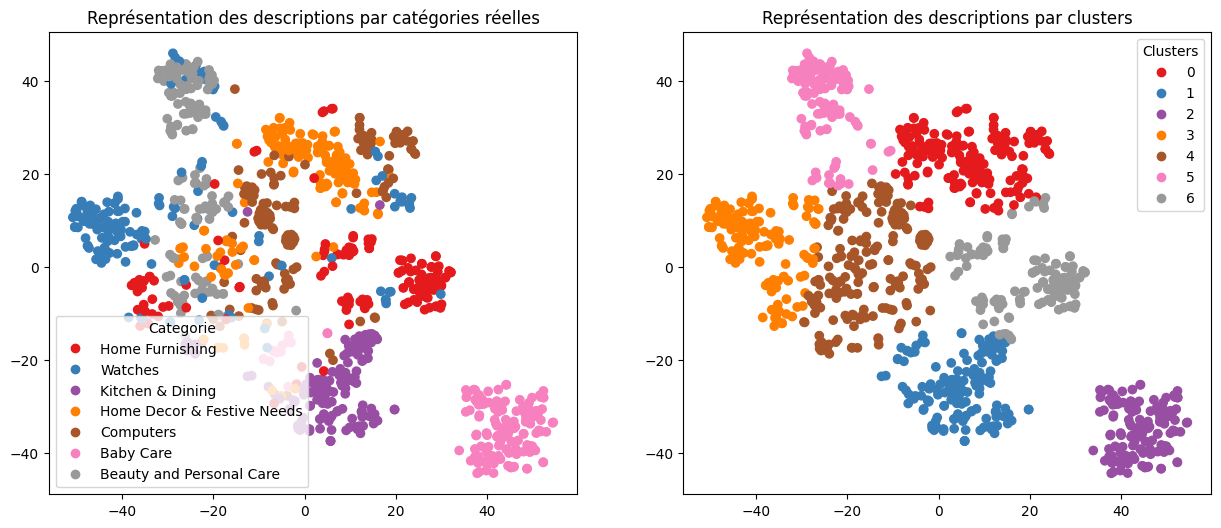

ARI :  0.4684


In [145]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> RESULTATS BERT-hub : </b> 
    
- ARI :  0.3929, max_length = 20
- <b> ARI :  0.4684, max_length = 30 </b>
- ARI :  0.3788, max_length = 40
- ARI :  0.3772, max_length = 50
- ARI :  0.3248, max_length = 100
    
</div>

### 3. USE

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder model is trained with a deep averaging network (DAN) encoder.

Our encoder differs from word level embedding models in that we train on a number of natural language prediction tasks that require modeling the meaning of word sequences rather than just individual words.

In [29]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [30]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [49]:
batch_size = 10
# sentences = articles_text_BERT['cleaned_description'].to_list() # Données en entrée 
sentences =  articles_text_BERT['cleaned_description'].to_list() # Données en entrée

In [51]:
features_USE = feature_USE_fct(sentences, batch_size)

In [52]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4401 time :  6.0


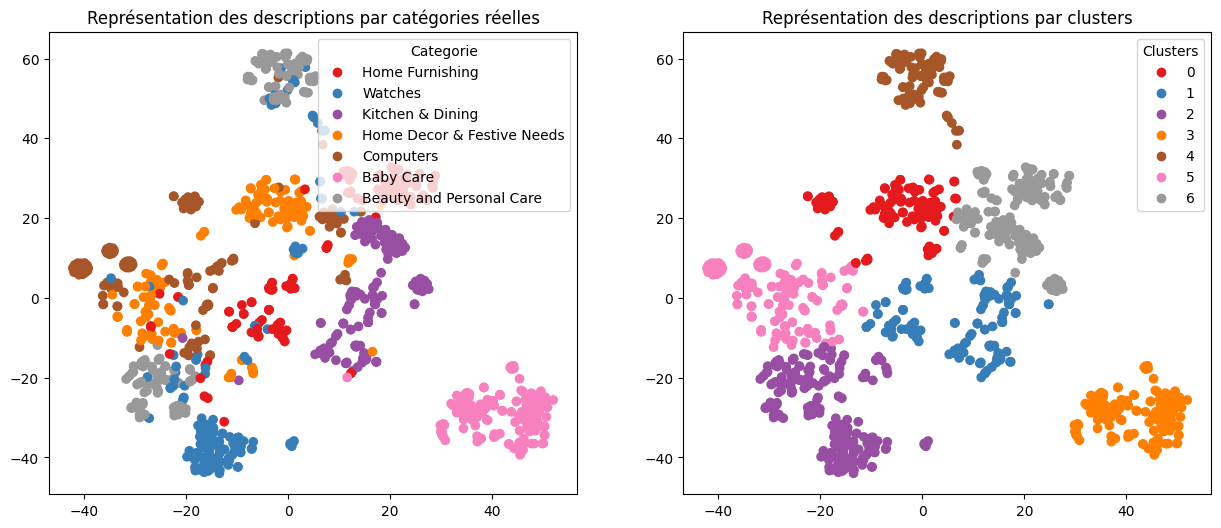

ARI :  0.4401


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> RESULTATS USE : </b> 
    
- ARI :  0.4401
    
</div>